# Normalize Data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Normalize-Data" data-toc-modified-id="Normalize-Data-1">Normalize Data</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#TOC" data-toc-modified-id="TOC-1.0.0.1">TOC</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Fetch-DataFrame-from-the-CSV-file" data-toc-modified-id="Fetch-DataFrame-from-the-CSV-file-2">Fetch DataFrame from the CSV file</a></span></li><li><span><a href="#Function-to-normalize-the-data" data-toc-modified-id="Function-to-normalize-the-data-3">Function to normalize the data</a></span></li><li><span><a href="#Condense-Date-to-e.g.-Mar'48-on-x-axis" data-toc-modified-id="Condense-Date-to-e.g.-Mar'48-on-x-axis-4">Condense Date to e.g. Mar'48 on x-axis</a></span></li><li><span><a href="#Draw-plots" data-toc-modified-id="Draw-plots-5">Draw plots</a></span></li><li><span><a href="#Write-DataFrame-to-the-CSV-file" data-toc-modified-id="Write-DataFrame-to-the-CSV-file-6">Write DataFrame to the CSV file</a></span></li></ul></div>

#### TOC
- [Provide Use Case Parameters](#Provide-Use-Case-Parameters)
- [Read DataFrame from the CSV file](#Read-DataFrame-from-the-CSV-file)
- [Function to normalize the data](#Function-to-normalize-the-data)
- [Write DataFrame to the CSV file](#Write-DataFrame-to-the-CSV-file)

# Fetch DataFrame from the CSV file

In [67]:
date_format = "yyyy.mm.dd" # 2007.04.05

include("available_datasets.jl") 
dataset_file_name = available_datasets()[14,2] # row 5, column 2 = TPLGX.csv

include("fetch_dataset.jl") 
df = fetch_dataset(dataset_file_name, date_format)

size(df)

usage: df = available_datasets() # returns a DataFrame with all available data sets (name, file_path)
usage: dataset_file_name = available_datasets()[5,2] # 5th dataset: DJIA, 2nd column: file-name

        usage: 
            include("available_datasets.jl") 
            dataset_file_name = available_datasets()[5,2] # row 5, column 2 = DJIA
            df = fetch_dataset(dataset_file_name)
    


(254, 7)

# Function to normalize the data

- takes a column (an array) of data as an input
- calculates minimum value of the column
- calculates maximum value of the column
- for each row it calculates:

$$ normalized_i = \frac{(value_i - min_{all})}{(max_{all} - min_{all})} $$

OR 

$$ x_i = \frac{(x_i - μ)}{σ} $$

where:
- μ  - **mean** of the whole population
- σ - **standard deviation** of the whole population

In [58]:
df[:, 2]

254-element Array{Float64,1}:
 46.0
 45.950001
 46.099998
 45.75
 45.580002
 44.98
 45.330002
 45.119999
 44.5
 44.790001
 44.27
 43.57
 44.09
  ⋮
 64.760002
 65.529999
 62.549999
 61.27
 59.119999
 60.549999
 59.34
 58.939999
 59.68
 60.349998
 59.610001
 58.880001

In [59]:
# sample the values in the columns
columns = names(df)
for i in 1:length(columns)
    println(i, " ", columns[i])
end

1 Date
2 Open
3 High
4 Low
5 Close
6 Adj Close
7 Volume


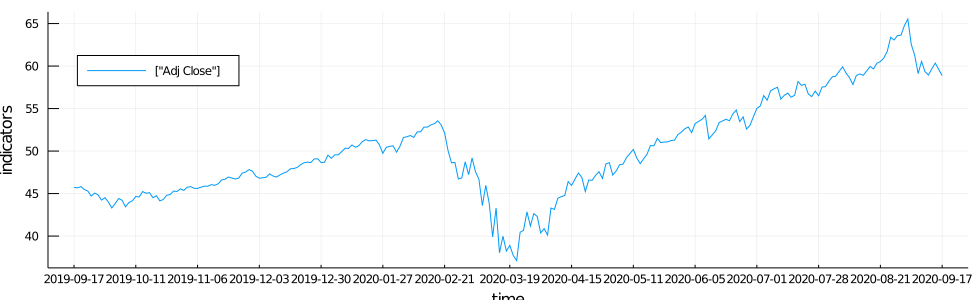

In [60]:
using Plots

rows = 1:length(df[rows,6])
gr()
plot(df[ rows,1 ], 
    [           df[rows,6]   ], 
    label    = [columns[6]   ],
    legend   =:topleft, 
              # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "indicators",
    size     = (980, 300), # width, height
    layout = (1, 1)
    )

In [68]:
using Statistics 

# Fit dataset in range [-128, 127]
# https://www.tensorflow.org/lite/performance/quantization_spec?hl=fi
# https://en.wikipedia.org/wiki/Standard_score
# https://www.wikihow.com/Calculate-Standard-Deviation
# http://www.differencebetween.net/science/difference-between-average-and-mean/
# 
function quantize_column!(df::DataFrame, column_number::Int64)
    original = df[:, column_number] # Array{Float64,1}
    items = length(original) 
    
    min = minimum(original)
    max = maximum(original)
    population_mean = mean(original)
    standard_deviation = std(original)
    
    bias = (0 - min)/(max-min)
    println("bias: ", bias)

    for i in 1:items
        value = (original[i] - min) / (max - min) # normalization formula 0.0 to 1.0
        #value = value + bias
        #value = (original[i] - population_mean) / standard_deviation
        value = value * 255                    # 0.0 to 255
        value = value - 128                    # -127 to 127
        value = round(value, digits=0)         # 0.00 
        df[i, normalized_column] = value
    end
    return df[:, normalized_column]
end

println("minimum(original): ", minimum(df[6]) )
println("maximum(original): ", maximum(df[6]) )

data_normalized = quantize_column!(df, 6)


println("minimum(original): ", minimum(df[6]) )
println("maximum(original): ", maximum(df[6]) )

minimum(original): 37.110001
maximum(original): 65.529999
bias: -1.3057707111731671
minimum(original): -128.0
maximum(original): 127.0


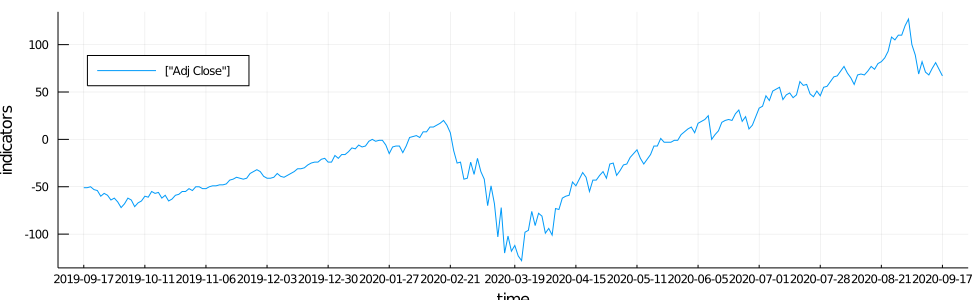

In [69]:
using Plots

rows = 1:254
gr()
plot(df[ rows,1 ], 
    [           df[rows,6]   ], 
    label    = [columns[6]   ],
    legend   =:topleft, 
              # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "indicators",
    size     = (980, 300), # width, height
    layout = (1, 1)
    )

# Condense Date to e.g. Mar'48 on x-axis

- Since multiple rows share one year, using just year makes a choppy graph.
- Since days of the month are missing and are are not evenly spaced, it is bad idea to use them.
- Since we have all the months they make for acceptable values on the x-axis.
- In the future, I might create more granual scale.

In [3]:
dates = df[:,2] # e.g. 1948-03-31
columns = length(dates)
periods = Array{String, 1}(undef, columns) # define array to hold x-axis values

for i in 1:columns
    periods[i] = string( Dates.format(dates[i], "u'yy")  ) # e.g. Mar'48
end
periods

LoadError: UndefVarError: df not defined

# Draw plots

If the normalization above was done right, the plots retain exactly same shape, regardless that y-axis (vertical) is scaled.

- https://docs.juliaplots.org/latest/layouts/

In [4]:
gr()
plot(periods, 
    [df[:,original_column]  df[:,normalized_column]  ], 
    label    = ["original" "normalized"],
    legend    =:topleft, # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "indicators",
    size     = (1750, 600), # width, height
    layout = (2, 1)
    )

LoadError: UndefVarError: df not defined

# Write DataFrame to the CSV file

In [5]:
CSV.write(file_name, df, delim=',', header=true)

LoadError: UndefVarError: df not defined

In [6]:
show(df[:,original_column:normalized_column], allcols=true)

LoadError: UndefVarError: df not defined

In [7]:
data1 = df[:,4] # Manufacturing
data2 = df[:,6]

gr()
plot(periods, 
    [ data1  data2 ], 
    label    = ["ISM Manufacturing norm." "GDP q/q norm."],
    legend    =:topleft, # :right, :left, :top, :bottom, :inside, :best, :legend, :topright, :topleft, :bottomleft, :bottomright
    xlabel   = "time",
    ylabel   = "indicators",
    size     = (1750, 600), # width, height
    layout = (1, 1)
    )

LoadError: UndefVarError: df not defined